# Poiseuille

In [57]:
include("notebook_examples.jl");
using Logging, TerminalLoggers, ProgressMeter

## Velocity profile

In [30]:
Nₓ = 32
Nₓ = 4
problem = PoiseuilleFlow(1.0 / 6.0, Nₓ)
ν = LatticeBoltzmann.viscosity(problem)
Δt = delta_t(problem)
snapshot_at =[0.01, 0.05, 0.1, 1.0]
q = D2Q9()

snapshot_results = simulate(
    problem,
    q,
    t_end = 5.0 / LatticeBoltzmann.viscosity(problem),
    process_method = LatticeBoltzmann.TakeSnapshots(problem, round.(Int, snapshot_at ./ (ν * Δt))),
    initialization_strategy = LatticeBoltzmann.ZeroVelocityInitialCondition(),
);

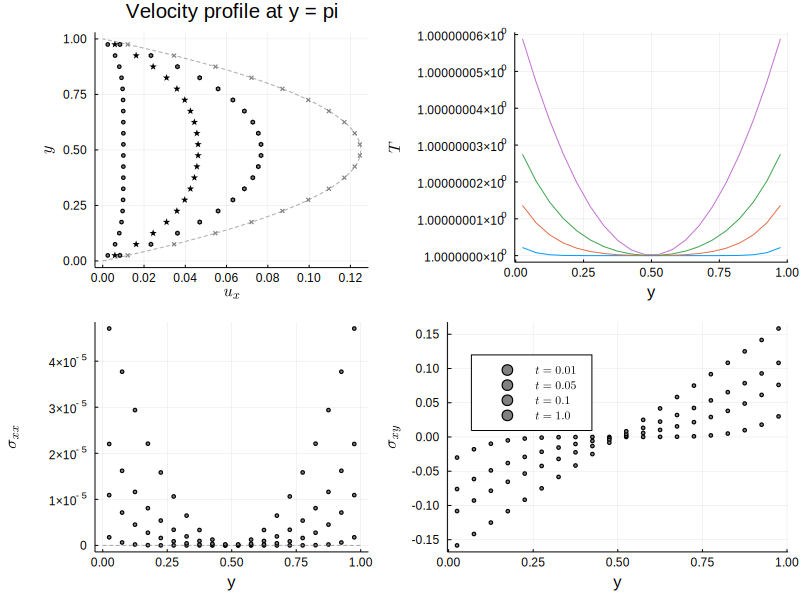

In [55]:
result = snapshot_results
plots = plot_snapshots(problem, result.processing_method.snapshots, snapshot_at, q)

plot(
    plot!(plots.velocity_profile_y, legend = false),
    plot!(plots.temperature_profile, legend = false),
    plot!(plots.sigma_xx_profile, legend = false),
    plot!(plots.sigma_xy_profile, legend = :topleft),
    size=(800, 600),
    markrershape = :diamond,
    markercolor = :gray,
    markersize = 2,
)

## Optimal relaxation time SRT

In [58]:
function solve(problem, q, τ_s, τ_a)
    # Choose an end time such that we can be certain that a steady state solution
    # has been found before terminating
    t_end = 100.0
    Δt = LatticeBoltzmann.delta_t(problem)
    n_steps = round(Int, t_end / Δt)

    process_method = TrackHydrodynamicErrors(
        problem,
        false,
        n_steps,
        LatticeBoltzmann.VelocityConvergenceStoppingCriteria(1E-7, problem)
    )

    collision_model = LatticeBoltzmann.TRT(
        τ_s,
        τ_a,
        (x_idx, y_idx, t) -> LatticeBoltzmann.lattice_force(problem, x_idx, y_idx, t)
    )

    result = LatticeBoltzmann.simulate(
        problem,
        q,
        t_end = t_end,
        should_process = false,
        collision_model = collision_model,
        process_method = process_method,
        initialization_strategy = ZeroVelocityInitialCondition(),
    )

    return result
end


function main(quadratures = [D2Q9()], scale = 2, τ_s_range = range(0.51, stop = 10.0, step = 0.01), τ_a_range = τ_s_range)
    with_logger(TerminalLogger(stderr, Logging.Warn)) do
        s = []
        for q in quadratures
            @showprogress "Computing optimal relaxation times..." for τ_s in τ_s_range, τ_a in τ_a_range

                ν = (τ_s - 0.5) / q.speed_of_sound_squared
                problem = PoiseuilleFlow(ν, scale)

                result = solve(problem, q, τ_s, τ_a)
                errors = result.processing_method.df[end]

                push!(s, (
                    τ_s = τ_s,
                    τ_a = τ_a,
                    quadrature = q,
                    error_u = errors.error_u,
                    error_p = errors.error_p,
                    error_σ_xx = errors.error_σ_xx,
                    error_σ_xy = errors.error_σ_xy
                ))
            end
        end
        return s
    end
end

main (generic function with 5 methods)

In [59]:
τs = range(0.51, stop = 10.0, step=0.01)
τs = range(0.51, stop = 10.0, step=0.01)
@load "trt_magic_parameter_001.jld2"

1-element Array{Symbol,1}:
 :results

In [61]:
τ_as = map(d -> d.τ_a, results) |> unique;
τ_ss = map(d -> d.τ_s, results) |> unique;
result_by_taus = map(results) do r
    (r.τ_s, r.τ_a) => r.error_u
end |> Dict;

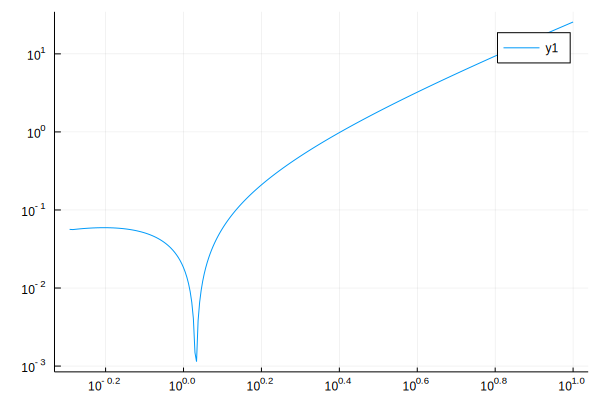

In [63]:
plot(τ_as, (τ) -> result_by_taus[τ, τ], scale=:log10)

## Optimal relaxation time TRT

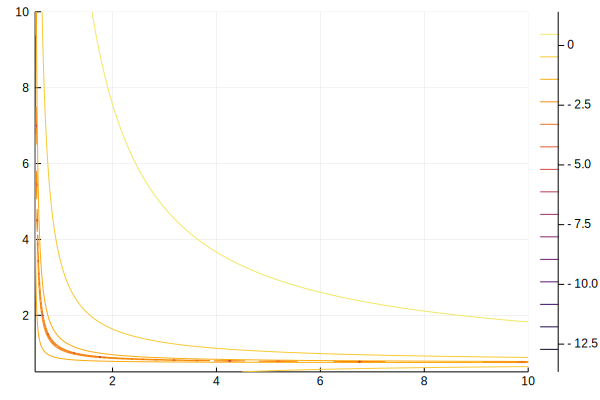

In [64]:
contour(τ_ss, τ_as, ((a, b) -> result_by_taus[(a, b)] |> log10))

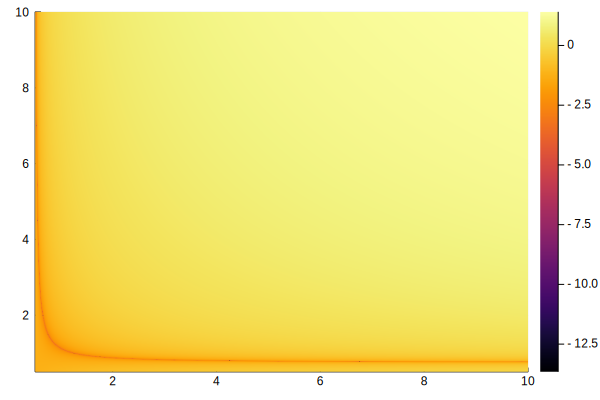

In [65]:
heatmap(τ_ss, τ_as, ((a, b) -> result_by_taus[(a, b)] |> log10))